## Web traffic- JustTraining- Final
After data is loaded and concated and saved we can move it over here for actual training.

Again, this is using the information from Jeremy Howards's data. 
https://www.youtube.com/watch?v=1-NYPQw5THU&feature=youtu.be

In [1]:
# I enjoyed having a command console to set everything up for a run
# How many rows should we have remaining
# 0 means everyone
tableNumMod= 0

# Are we filling the submission data?
SubmissionRun = True
# How many columns should be here
#Array size is 794 : 794 ran out of data
# 512 low dropout = 10 epochs
# 512 - 10 minutes = 10 epochs 1 set of 14: : Weights 24.1782 : webTraffic480x512x10FI.h5
# 256 - 20 minutes = 10 epochs
# 128 - 40 minutes = 10 epochs 2 sets of 5 : 23.7681 : Weights webTraffic480x128x5FI.h5
# 64 - 70 Minutes = 10 epochs 
tableColMod= 480

BatchNumber= 512
EpochNumber= 10

#webTraffic480x512x1FI.h5 
#Names the instance for all files
#instanceName= str(tableColMod)+"x"+str(BatchNumber)+"x"+str(EpochNumber)+"FI"

# At some point you know what you want! Everything train to here
instanceName="480x512x1FI"

## Setup

In [3]:
# I like the dings! You can comment this out
get_ipython().magic('load_ext cellevents')

In [2]:
## Import sound alert dependencies
## I personally enjoy earthbound soundtrack
from IPython.display import Audio, display

def allDone():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/eb_win.wav', autoplay=True))
    
def RunningEpochs():
    #display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    display(Audio(url='http://starmen.net/mother2/soundfx/enterbattle.wav', autoplay=True))
## Insert whatever audio file you want above


In [5]:
%matplotlib inline

time: 168 ms


In [6]:
# Include all the imports
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
import h5py
from keras.models import load_model
import keras.backend as K
import pandas as pd
from datetime import datetime
import re
from tensorflow.python.client import device_lib
from utils2 import *
# Breaks out dates into good data
from isoweek import Week
from pandas_summary import DataFrameSummary
# Options determine the way floating point numbers, arrays and other NumPy objects are displayed
np.set_printoptions(threshold=20, edgeitems=10)
from IPython.display import HTML
from datetime import datetime

date = datetime.strptime("2015-07-01", "%Y-%m-%d")  

Using TensorFlow backend.
/home/jd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


time: 2.27 s


In [7]:
# Limits the amount of GPU is used up
#limit_mem()
import tensorflow as tf

time: 3.37 ms


In [8]:
# Makes sure my GPUs are here
print (device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 31019368910364920
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7938919629
locality {
  bus_id: 1
}
incarnation: 11646440506844079390
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 7950188544
locality {
  bus_id: 1
}
incarnation: 7595427203757147786
physical_device_desc: "device: 1, name: GeForce GTX 1080, pci bus id: 0000:06:00.0"
]
time: 298 ms


In [9]:
# Set up pathing
path = '/home/jd/data/webTraffic/'

time: 598 µs


### Functions
Some of these functions are not used

In [10]:
# Is used to merge the pandas together
# Used in Data Cleaning
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

time: 2.02 ms


In [11]:
# Basic class
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date
        return row.Date-self.last

time: 6.41 ms


In [12]:
def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

time: 4.25 ms


In [13]:
# Makes life very easy.. learn more about it
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

time: 9.47 ms


In [14]:
#Used in validation
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

time: 923 µs


In [15]:
#Used in validation
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

time: 1.74 ms


In [16]:
# Will need to switch this out
# Used in modeling
from numba import jit
import math

def rmspe(y_pred, targ ):# target = y_valid_orig
    pct_var = (targ - y_pred)/targ
    return math.sqrt(np.square(pct_var).mean())

time: 188 ms


In [17]:
# Used at the end of models 
def log_max_inv(preds, mx ): #mx= max_log_y
    return np.exp(preds * mx)

time: 998 µs


In [18]:
# Used at the end of models 
def normalize_inv(preds):
    return preds * ystd + ymean

time: 2.77 ms


In [19]:
# Used for making the models
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

time: 929 µs


In [20]:
# Used for making the models
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

time: 1.09 ms


In [21]:
# Used for making the models
def my_init(scale):
    return lambda shape, name=None: initializations.uniform(shape, scale=scale, name=name)

time: 4.25 ms


In [22]:
# Used for making the models
def emb_init(shape, name=None): 
    return initializations.uniform(shape, scale=2/(shape[1]+1), name=name)

time: 1.12 ms


In [23]:
# Used for making the models
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', init=my_init(1.))(inp)

time: 4.24 ms


In [24]:
# Used for making the models
def get_emb(feat):
    name, c = cat_map_info(feat)
    #c2 = cat_var_dict[name]
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    # , W_regularizer=l2(1e-6)
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, init=emb_init)(inp))
#     u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    return inp,u

time: 5.13 ms


## Load Pickles
https://vignette2.wikia.nocookie.net/rickandmorty/images/7/7b/Picklerick.jpg/revision/latest?cb=20170725205548
In order to speed up the process I saved some variable data in pickle form.

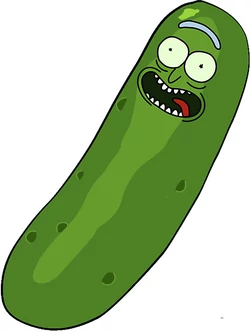

In [25]:
with open(r"cat_maps.pickle", "rb") as input_file:
    cat_map_fit = pickle.load(input_file)
with open(r"contin_maps.pickle", "rb") as input_file:
    contin_map_fit = pickle.load(input_file)

time: 14.7 ms


In [26]:
with open(r"map_train.pickle", "rb") as input_file:
    map_train = pickle.load(input_file)
with open(r"y_train.pickle", "rb") as input_file:
    y_train = pickle.load(input_file)

time: 9.59 s


In [27]:
with open(r"map_valid.pickle", "rb") as input_file:
    map_valid = pickle.load(input_file)
with open(r"y_valid.pickle", "rb") as input_file:
    y_valid = pickle.load(input_file)

time: 4.13 s


In [28]:
with open(r"map_predict.pickle", "rb") as input_file:
    map_predict = pickle.load(input_file)
with open(r"y_predict.pickle", "rb") as input_file:
    y_predict = pickle.load(input_file)

time: 1.78 s


In [29]:
with open(r"joined.pickle", "rb") as input_file:
    tables = pickle.load(input_file)
with open(r"joined_train.pickle", "rb") as input_file:
    joined_train = pickle.load(input_file)

time: 38.2 s


In [30]:
with open(r"joined_valid.pickle", "rb") as input_file:
    joined_valid = pickle.load(input_file)
with open(r"joined_predict.pickle", "rb") as input_file:
    joined_predict = pickle.load(input_file)

time: 11.3 s


In [31]:
with open(r"contin_cols.pickle", "rb") as input_file:
    contin_cols = pickle.load(input_file)

time: 1.26 ms


In [32]:
with open(r"max_log_y.pickle", "rb") as input_file:
    max_log_y = pickle.load(input_file)
with open(r"y_train_orig.pickle", "rb") as input_file:
    y_train_orig = pickle.load(input_file)

time: 891 ms


In [33]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)

time: 34.3 ms


## Create Models

In [34]:
# Found sMAPE function from kaggle user Tilii gave the code to it below.
# https://www.kaggle.com/c/allstate-claims-severity/discussion/26461#150314
def sMAPE(y_true, y_pred):
    #Symmetric mean absolute percentage error
    return 200 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_pred) + K.abs(y_true)), axis=-1)

time: 3.3 ms


In [35]:
# Here is the model which is about exactly the same as the one from Jeremy
embs = [get_emb(feat) for feat in cat_map_fit.features]
x = merge([emb for inp,emb in embs] + [contin_out], mode='concat')

x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', init='uniform')(x)
x = Dense(500, activation='relu', init='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)
#model.compile('adam', mse)
model.compile(loss=sMAPE, optimizer = 'adam')
#model.compile('adam', 'mean_absolute_error')

time: 372 ms


### Start training


In [36]:
# Tried
model.lr=0.001

time: 610 µs


In [3]:
# We are very excited to get started!
RunningEpochs()

In [46]:
# Loads some of the old weights by instance name.
#webTraffic512x600.h5
#webTraffic256x600x2.h5 20 rounds
try:
    model.load_weights(path+'webTraffic'+instanceName+'.h5')
except:
    print ("Not Here")

time: 25.8 ms


In [47]:
# Runs the training. Wanted to figure how much time I would have until the end of the competition.
# I wanted weights saved based on the number of batches and epochs.

    
%%time
#Was nb_epoch=25
#Batch was 128
#64 = 1 Hr 16 Min
#128 = 40 min webTraffic500x128x3.h5
#256 = 20
#512 = 10
#1024 = 5

# Recommned replacing with information at top
hist = model.fit(map_train, y_train, batch_size=512, 
                 nb_epoch=1, verbose=1, validation_data=(map_valid, y_valid))

# This part was frozen when I realized it wouldn't finish in time.

Train on 49756609 samples, validate on 21324261 samples
Epoch 1/1
36139008/49756609 [====================>.........] - ETA: 159s - loss: 26.8991

KeyboardInterrupt: 

time: 7min 3s


In [ ]:
# Saves the weights to be used again later if needed.
model.save_weights(path+'webTraffic'+instanceName+'.h5',overwrite=False)

In [ ]:
# Provides the name where data was saved... just in case.
print(path+'webTraffic'+instanceName+'12.h5')

In [42]:
# Will list the the loss  
model.history
hist.history

time: 362 µs


## Predict this solution!
Predicts what everything will be. I wanted to predict for both Valid and prediction set. Knowing how the close the valid set was achieved visually lets me be certain prediction will work for the real thing.

In [ ]:
## Gets a list of my valid predictions
validpreds =model.predict(map_valid, 128, verbose=1)
listValidpreds=log_max_inv(validpreds,max_log_y)

In [50]:
# Gets a list of the predictions for submission (We don't know what these values are)
# 256 finishes in a minute
# 128 finishes in 2 minutes
Futurepreds=model.predict(map_predict, 256, verbose=1)

8993280/8993906 [============================>.] - ETA: 0stime: 54.1 s


In [51]:
#These are the values for submission corrected
listFuturepreds=log_max_inv(Futurepreds,max_log_y)

time: 83.9 ms


In [ ]:
# This graph was in Jeremy's code. I didn't find it as useful. I tried to add in the list of actual valids, 
# valid predictions, and future predictions, and the median.

#Real Values
plt.plot(joined_valid.Visits, color='g')
# Valid set trained
plt.plot(listValidpreds, color='black')
# Future predictions
plt.plot(listFuturepreds, color='b')
plt.axhline(y=tables.Visits.mean(), color='r')
plt.show()

In [52]:
#gets the ymean and ystd
ymean=y_train_orig.mean()
ystd=y_train_orig.std()

time: 141 ms


In [53]:
#len(listValidpreds)

time: 432 µs


In [55]:
# sets up both the newsubmission values (What will be submitted) to a the overall data
# sets up creates a new submission that holds the new valid visit values
newsubm = joined_predict.assign(Visits=pd.Series(listFuturepreds.flatten().tolist()))
sepsubm = joined_valid.assign(Visits=pd.Series(listValidpreds.flatten().tolist()))

time: 1.43 s


In [56]:
# I realized the night before that the date could be off. (Went to 2002)
# Left this check in
newsubm.sort_values(['Date'])

,Date,Page,Visits,Year,Month,Week,Day,DayOfWeek,name,locale,article,access,agent
0,2017-09-13,007_スペクター_ja.wikipedia.org_all-access_all-agents,593.442078,2017,9,37,13,2,007_スペクター,ja,wikipedia,all-access,all-agents
8618806,2017-09-13,藏_ja.wikipedia.org_all-access_all-agents,87.424294,2017,9,37,13,2,藏,ja,wikipedia,all-access,all-agents
363382,2017-09-13,Anexo:Medallero_de_los_Juegos_Olímpicos_de_Bar...,27.313860,2017,9,37,13,2,Anexo:Medallero_de_los_Juegos_Olímpicos_de_Bar...,es,wikipedia,all-access,all-agents
2880706,2017-09-13,ICE-Unfall_von_Eschede_de.wikipedia.org_all-ac...,297.065186,2017,9,37,13,2,ICE-Unfall_von_Eschede,de,wikipedia,all-access,all-agents
6020324,2017-09-13,Walisische_Fußballnationalmannschaft_de.wikipe...,8.820539,2017,9,37,13,2,Walisische_Fußballnationalmannschaft,de,wikipedia,all-access,spider
2880644,2017-09-13,Ice-T_en.wikipedia.org_mobile-web_all-agents,2114.944824,2017,9,37,13,2,Ice-T,en,wikipedia,mobile-web,all-agents
6020386,2017-09-13,Walisische_Fußballnationalmannschaft_de.wikipe...,31.399408,2017,9,37,13,2,Walisische_Fußballnationalmannschaft,de,wikipedia,desktop,all-agents
2880582,2017-09-13,Ice-T_en.wikipedia.org_all-access_spider,69.257744,2017,9,37,13,2,Ice-T,en,wikipedia,all-access,spider
6020448,2017-09-13,Walisische_Fußballnationalmannschaft_de.wikipe...,25.841322,2017,9,37,13,2,Walisische_Fußballnationalmannschaft,de,wikipedia,mobile-web,all-agents
2880520,2017-09-13,Ice-T_en.wikipedia.org_all-access_all-agents,4153.212402,2017,9,37,13,2,Ice-T,en,wikipedia,all-access,all-agents


time: 3.8 s


In [ ]:
# dataframes are great because they will show the mean for both. In theory they should be similar
display(DataFrameSummary(newsubm).summary())

In [ ]:
# dataframes are great because they will show the mean for both. In theory they should be similar
display(DataFrameSummary(tables).summary())

In [ ]:
# Probably my favorite function.
# It will create a list of 5 random graphs. It lets me see how close the valid predictions are to the valid values
# It also compares it with the mean visits for the row.
# I should have set it up to 


import random
for i in range(5):
    testname=joined_train['Page'][random.randint(0, len(joined_train))]
    # plt.plot(listValidpreds, color='black') sepsubm
    submit1=newsubm.loc[newsubm['Page'] == testname]
    submit2=joined_train.loc[joined_train['Page'] == testname]
    submit3=joined_valid.loc[joined_valid['Page'] == testname]
    submit4=sepsubm.loc[sepsubm['Page'] == testname]
    #print(submit3)
    #plt.plot(submit1.Visits, color='b')
    # it should run differently if I am running submissions or not.
    if (SubmissionRun):#/==False):
        # Predicted amounts
        plt.plot(submit3.Visits, color='b')
        # Valid amounts 
        plt.plot(submit4.Visits, color='g')
    plt.axhline(submit2.Visits.mean(), color='r')
    print (testname)
    print (len(submit1),len(submit3))
    print (submit2.Visits.mean())    
    plt.show()

#### Its time to save everything in pickles!
I wanted to play around with these numbers in another instance while training another model

In [ ]:
pickle.dump(newsubm, open('newsubm'+instanceName+'.pickle', 'wb'))

In [ ]:
pickle.dump(joined_train, open('joined_train'+instanceName+'.pickle', 'wb'))
pickle.dump(joined_valid, open('joined_valid'+instanceName+'.pickle', 'wb'))
pickle.dump(sepsubm, open('sepsubm'+instanceName+'.pickle', 'wb'))
pickle.dump(newsubm, open('newsubm'+instanceName+'.pickle', 'wb'))
pickle.dump(listFuturepreds, open('listFuturepreds'+instanceName+'.pickle', 'wb'))

In [ ]:
pickle.dump(ymean, open('ymean'+instanceName+'.pickle', 'wb'))
pickle.dump(ystd, open('ystd'+instanceName+'.pickle', 'wb'))

In [ ]:
#We are done!! Victory!
allDone()

In [57]:
# Does this look right-ish?
newsubm

,Date,Page,Visits,Year,Month,Week,Day,DayOfWeek,name,locale,article,access,agent
0,2017-09-13,007_スペクター_ja.wikipedia.org_all-access_all-agents,593.442078,2017,9,37,13,2,007_スペクター,ja,wikipedia,all-access,all-agents
1,2017-09-14,007_スペクター_ja.wikipedia.org_all-access_all-agents,580.276611,2017,9,37,14,3,007_スペクター,ja,wikipedia,all-access,all-agents
2,2017-09-15,007_スペクター_ja.wikipedia.org_all-access_all-agents,629.586731,2017,9,37,15,4,007_スペクター,ja,wikipedia,all-access,all-agents
3,2017-09-16,007_スペクター_ja.wikipedia.org_all-access_all-agents,814.178711,2017,9,37,16,5,007_スペクター,ja,wikipedia,all-access,all-agents
4,2017-09-17,007_スペクター_ja.wikipedia.org_all-access_all-agents,853.956116,2017,9,37,17,6,007_スペクター,ja,wikipedia,all-access,all-agents
5,2017-09-18,007_スペクター_ja.wikipedia.org_all-access_all-agents,692.107666,2017,9,38,18,0,007_スペクター,ja,wikipedia,all-access,all-agents
6,2017-09-19,007_スペクター_ja.wikipedia.org_all-access_all-agents,604.697815,2017,9,38,19,1,007_スペクター,ja,wikipedia,all-access,all-agents
7,2017-09-20,007_スペクター_ja.wikipedia.org_all-access_all-agents,589.121826,2017,9,38,20,2,007_スペクター,ja,wikipedia,all-access,all-agents
8,2017-09-21,007_スペクター_ja.wikipedia.org_all-access_all-agents,597.418091,2017,9,38,21,3,007_スペクター,ja,wikipedia,all-access,all-agents
9,2017-09-22,007_スペクター_ja.wikipedia.org_all-access_all-agents,647.230530,2017,9,38,22,4,007_スペクター,ja,wikipedia,all-access,all-agents


time: 33.4 ms


## Last Minute Add
IDs were ripped out and I needed to put them back in.

In [ ]:
newsubm.sort_values("Date")

In [59]:
# This was my lastditch. Oh Hai I need those IDs back in
with open(r"ThebestestKey.pickle", "rb") as input_file:
    ThebestestKey = pickle.load(input_file)

time: 9.21 s


In [60]:
# Sets Newsubm a certain way
newsubm=newsubm.sort_values(['Page', 'Date'])

time: 3.73 s


In [61]:
# Does the same with thebestestKey
ThebestestKey=ThebestestKey.sort_values(['Page', 'Date'])

time: 18.2 s


In [62]:
#Puts the Ids into newSubm
newsubm["Id"]=ThebestestKey.Id

time: 111 ms


## Submit File
For when all the predictions and visits have been guessed.

In [63]:
# Subm 
## ss_id are the ids; Combines page and date
## is the predicted visits for the page and date
subm2 = pd.DataFrame({'Id': newsubm.Id, 'Visits': newsubm.Visits})

time: 118 ms


In [64]:
# Does it look ok?
subm2[:5]

,Id,Visits
6009102,fcc80b534ec3,3.736170
6009103,cb546ce1d7f1,3.641545
6009104,df76aa5db9b3,3.861362
6009105,d7a6e8477c1f,4.485296
6009106,f3dc8ae4c23a,3.720148


time: 8.53 ms


In [65]:
# Makes the submission name out of folders
#Makes sure we provide the latest and greatest
numFiles=len(os.listdir(path+'submits/'))
subm_name = 'submission'+str(numFiles)+'.csv.gz'
submission=subm2

time: 6.94 ms


In [66]:
#Gets the submission made to gzip file
submission.to_csv((path+'submits/'+subm_name), index=False, compression='gzip')

time: 32.8 s


In [67]:
#Download to submit
print ('http://localhost:8888/view/data/webTraffic/submits/'+subm_name)

http://localhost:8888/view/data/webTraffic/submits/submission34.csv.gz
time: 692 µs


In [68]:
#We are done!! Victory!
allDone()

time: 8.51 ms
